# Hyperparameters and lags search: backtesting vs one-step-ahead

Hyperparameter and lag tuning involves systematically testing different values or combinations of hyperparameters (and/or lags) to find the optimal configuration that gives the best performance. The **skforecast** library provides two different methods to evaluate each candidate configuration:

+ Backtesting: In this method, the model predicts several steps ahead in each iteration, using the same forecast horizon and retraining frequency strategy that would be used if the model were deployed. This simulates a real forecasting scenario where the model is retrained and updated over time.

+ One-Step Ahead: Evaluates the model using only one-step-ahead predictions. This method is faster because it requires fewer iterations, but it only tests the model's performance in the immediate next time step.

Each method uses a different evaluation strategy, so they may produce different results. However, in the long run, both methods are expected to converge to similar selections of optimal hyperparameters. The one-step-ahead method is much faster than backtesting because it requires fewer iterations, but it only tests the model's performance in the immediate next time step. It is recommended to backtest the final model for a more accurate multi-step performance estimate.

This document compares the results of each approach when applied to different forecasters and datasets. To do this, the skforecast functions `grid_search_forecaster`, `bayesian_search_forecaster`, `grid_search_forecaster_multiseries` and `bayesian_search_forecaster_multiseries` are used to search for the optimal hyperparameters and lags for each forecaster using the backtesting and one-step-ahead methods, respectively. The search is performed on the validation dataset, and the best configuration is then backtested on the test dataset. The time required to perform the search for each method is recorded, as is the performance of the best configuration found.

!!!!!!Mostrar plot con los resultados!!!

In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent))
str(Path.cwd().parent)

'/home/ubuntu/varios/skforecast'

## Libraries

In [2]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from copy import copy
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from skforecast.datasets import fetch_dataset
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.ForecasterAutoregMultiVariate import ForecasterAutoregMultiVariate
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import grid_search_forecaster_multiseries
from skforecast.model_selection_multiseries import bayesian_search_forecaster_multiseries

# Warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

## Data sets

In [3]:
data_h2o = fetch_dataset(name="h2o", raw=False, verbose=False)
data_bike = fetch_dataset('bike_sharing_extended_features', verbose=False)
data_sales = fetch_dataset(name="items_sales", verbose=False)

data_website = fetch_dataset(name="website_visits", raw=True, verbose=False)
data_website['date'] = pd.to_datetime(data_website['date'], format='%d/%m/%y')
data_website = data_website.set_index('date')
data_website = data_website.asfreq('1D')
data_website = data_website.sort_index()
data_website['month'] = data_website.index.month
data_website['month_day'] = data_website.index.day
data_website['week_day'] = data_website.index.day_of_week
data_website = pd.get_dummies(data_website, columns=['month', 'week_day', 'month_day'], dtype='int64')

data = fetch_dataset(name='vic_electricity', raw=False, verbose=False)
data = data.drop(columns="Date")
data = (
    data
    .resample(rule="h", closed="left", label="right")
    .agg({
        "Demand": "mean",
        "Temperature": "mean",
        "Holiday": "mean",
    })
)
data = data.loc['2012-01-01 00:00:00': '2014-12-30 23:00:00'].copy()

## Single series forecasters

In [4]:
# Functions to compare results using backtesting and one step ahead
# ==============================================================================
def run_benchmark(
    data,
    forecaster_to_benchmark,
    search_method = None,
    lags_grid = None,
    param_grid = None,
    search_space = None,
    end_train = None,
    end_validation = None,
    target = None,
    exog_features = None,
    steps = None,
    metric = None
):
    """
    Compare results of grid search and bayesian search using backtesting and one-step-ahead.
    """
    
    # backtesting
    forecaster = copy(forecaster_to_benchmark)
    start  = time()
    if search_method == 'grid_search':
        results_1 = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data.loc[:end_validation, target],
                        exog               = data.loc[:end_validation, exog_features] if exog_features else None,
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = False,
                        metric             = metric,
                        initial_train_size = len(data.loc[:end_train]),
                        method             = 'backtesting',
                        fixed_train_size   = False,
                        return_best        = True,
                        n_jobs             = 'auto',
                        verbose            = False,
                        show_progress      = True
                    )
    else:
        results_1, _ = bayesian_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data.loc[:end_validation, target],
                        exog               = data.loc[:end_validation, exog_features] if exog_features else None,
                        search_space       = search_space,
                        steps              = steps,
                        refit              = False,
                        metric             = metric,
                        initial_train_size = len(data.loc[:end_train]),
                        method             = 'backtesting',
                        fixed_train_size   = False,
                        n_trials           = 15,
                        random_state       = 123,
                        return_best        = True,
                        n_jobs             = 'auto',
                        verbose            = False,
                        show_progress      = True
                    )

    end = time()
    time_1 = end - start
    metric_1, pred_1 = backtesting_forecaster(
                        forecaster          = forecaster,
                        y                   = data.loc[:, target],
                        exog                = data.loc[:, exog_features] if exog_features else None,
                        initial_train_size  = len(data.loc[:end_validation]),
                        steps               = steps,
                        metric              = metric,
                        verbose             = False,
                        show_progress       = False
                        )

    # One step ahead
    forecaster = copy(forecaster_to_benchmark)
    start  = time()
    if search_method == 'grid_search':
        results_2 = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data.loc[:end_validation, target],
                        exog               = data.loc[:end_validation, exog_features] if exog_features else None,
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        metric             = metric,
                        initial_train_size = len(data.loc[:end_train]),
                        method             = 'one_step_ahead',
                        return_best        = True,
                        verbose            = False,
                        show_progress      = True
                    )
    else:
        results_2, _ = bayesian_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data.loc[:end_validation, target],
                        exog               = data.loc[:end_validation, exog_features] if exog_features else None,
                        steps              = steps,
                        search_space       = search_space,
                        metric             = metric,
                        initial_train_size = len(data.loc[:end_train]),
                        method             = 'one_step_ahead',
                        n_trials           = 15,
                        random_state       = 123,
                        return_best        = True,
                        verbose            = False,
                        show_progress      = True
                    )

    end = time()
    time_2 = end - start
    metric_2, pred_2 = backtesting_forecaster(
                        forecaster          = forecaster,
                        y                   = data.loc[:, target],
                        exog                = data.loc[:, exog_features] if exog_features else None,
                        initial_train_size  = len(data.loc[:end_validation]),
                        steps               = steps,
                        metric              = metric,
                        verbose             = False,
                        show_progress       = False
                        )

    print("Benchmark results")
    print("-----------------")
    print('Execution time backtesting   :', time_1)
    print('Execution time one step ahead:', time_2)
    print(f"Same lags  : {np.array_equal(results_1.loc[0, 'lags'], results_2.loc[0, 'lags'])}")
    print(f"Same params: {results_1.loc[0, 'params'] == results_2.loc[0, 'params']}")
    print("")
    print("Method: backtesting")
    print(f"    lags   : {results_1.loc[0, 'lags']}")
    print(f"    params : {results_1.loc[0, 'params']}")
    print(f"    metrics: {metric_1.loc[0, metric]}")
    print("")
    print("Method: one step ahead")
    print(f"    lags   : {results_2.loc[0, 'lags']}")
    print(f"    params : {results_2.loc[0, 'params']}")
    print(f"    metrics: {metric_2.loc[0, metric]}")
    
    return time_1, time_2, metric_1.loc[0, metric], metric_2.loc[0, metric]

### Grid search

In [5]:
# Results
# ==============================================================================
results_grid_search = []

In [6]:
# Dataset: H2O
# ==============================================================================
end_train = "2001-01-01 23:59:00"
end_validation = "2006-01-01 23:59:00"
exog_features = None

forecaster = ForecasterAutoreg(
                regressor = LGBMRegressor(random_state=123, verbose=-1),
                lags      = 10
            )

lags_grid = [3, 10, [1, 2, 3, 20]]

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [2, 3, 5]
}

time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_h2o,
    forecaster_to_benchmark = forecaster,
    search_method           = 'grid_search',
    lags_grid               = lags_grid,
    param_grid              = param_grid,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'x',
    exog_features           = exog_features,
    steps                   = 12,
    metric                  = 'mean_absolute_error'
)

results_grid_search.append([
    'h20',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3 20] 
  Parameters: {'max_depth': 2, 'n_estimators': 100}
  Backtesting metric: 0.18240283368659635



lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 2, 'n_estimators': 100}
  Backtesting metric: 0.16147435680094147

Benchmark results
-----------------
Execution time backtesting   : 1.0723116397857666
Execution time one step ahead: 0.22062134742736816
Same lags  : False
Same params: True

Method: backtesting
    lags   : [ 1  2  3 20]
    params : {'max_depth': 2, 'n_estimators': 100}
    metrics: 0.22615930424513603

Method: one step ahead
    lags   : [ 1  2  3  4  5  6  7  8  9 10]
    params : {'max_depth': 2, 'n_estimators': 100}
    metrics: 0.13519201944243026


In [7]:
# Dataset: bike_sharing_extended_features
# ==============================================================================
end_train = '2012-03-31 23:59:00'
end_validation = '2012-08-31 23:59:00'
exog_features = [
    'month_sin', 'month_cos', 'week_of_year_sin', 'week_of_year_cos', 'week_day_sin',
    'week_day_cos', 'hour_day_sin', 'hour_day_cos', 'sunrise_hour_sin', 'sunrise_hour_cos',
    'sunset_hour_sin', 'sunset_hour_cos', 'holiday_previous_day', 'holiday_next_day',
    'temp_roll_mean_1_day', 'temp_roll_mean_7_day', 'temp_roll_max_1_day',
    'temp_roll_min_1_day', 'temp_roll_max_7_day', 'temp_roll_min_7_day',
    'temp', 'holiday'
]

forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 10
             )
lags_grid = [48, 72, (1, 2, 3, 23, 24, 25, 167, 168, 169)]

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 3, 5],
    'learning_rate': [0.01, 0.1, 0.5]
}

time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_bike,
    forecaster_to_benchmark = forecaster,
    search_method           = 'grid_search',
    lags_grid               = lags_grid,
    param_grid              = param_grid,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'users',
    exog_features           = exog_features,
    steps                   = 24,
    metric                  = 'mean_absolute_error'
)

results_grid_search.append([
    'bike_sharing',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/27 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3  23  24  25 167 168 169] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
  Backtesting metric: 61.780831638280475



lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/27 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
  Backtesting metric: 40.35201898407563

Benchmark results
-----------------
Execution time backtesting   : 251.46381330490112
Execution time one step ahead: 17.440540552139282
Same lags  : False
Same params: True

Method: backtesting
    lags   : [  1   2   3  23  24  25 167 168 169]
    params : {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
    metrics: 58.276762590192014

Method: one step ahead
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 

In [8]:
# Dataset: bike_sharing_extended_features
# ==============================================================================
forecaster = ForecasterAutoregDirect(
                 regressor = Ridge(random_state=123),
                 steps     = 24,
                 lags      = 10
             )

lags_grid = [48, 72, [1, 2, 3, 23, 24, 25, 167, 168, 169]]

param_grid = {'alpha': np.logspace(-3, 3, 10)}

time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_bike,
    forecaster_to_benchmark = forecaster,
    search_method           = 'grid_search',
    lags_grid               = lags_grid,
    param_grid              = param_grid,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'users',
    exog_features           = exog_features,
    steps                   = 24,
    metric                  = 'mean_absolute_error'
)
results_grid_search.append([
    'bike_sharing',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'alpha': 1000.0}
  Backtesting metric: 80.09100487004237



lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3  23  24  25 167 168 169] 
  Parameters: {'alpha': 1000.0}
  Backtesting metric: 193.2800595546969

Benchmark results
-----------------
Execution time backtesting   : 34.83490300178528
Execution time one step ahead: 12.574597120285034
Same lags  : False
Same params: True

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72]
    params : {'alpha': 1000.0}
    metrics: 79.0066262802451

Method: one step ahead
    lags   : [  1   2   3  23  24  25 167 168 169]
    params : {'alpha': 1000.0}
    metrics: 113.24578507529507


In [9]:
# Dataset: website_visits
# ==============================================================================
end_train = '2021-03-30 23:59:00'
end_validation = '2021-06-30 23:59:00'
exog_features = [col for col in data_website.columns if col.startswith(('month_', 'week_day_', 'month_day_'))]

forecaster = ForecasterAutoreg(
                 regressor     = Ridge(random_state=123),
                 transformer_y = StandardScaler(),
                 lags          = 10
             )

lags_grid = [7, 14, 21, [7, 14, 21]]

param_grid = {'alpha': np.logspace(-3, 3, 10)}

time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_website,
    forecaster_to_benchmark = forecaster,
    search_method           = 'grid_search',
    lags_grid               = lags_grid,
    param_grid              = param_grid,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'users',
    exog_features           = exog_features,
    steps                   = 7,
    metric                  = 'mean_absolute_error'
)
results_grid_search.append([
    'website',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
  Parameters: {'alpha': 10.0}
  Backtesting metric: 217.4710279660212



lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
  Parameters: {'alpha': 2.154434690031882}
  Backtesting metric: 0.13819498740066696

Benchmark results
-----------------
Execution time backtesting   : 4.0702433586120605
Execution time one step ahead: 0.29689955711364746
Same lags  : True
Same params: False

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
    params : {'alpha': 10.0}
    metrics: 165.59443777438304

Method: one step ahead
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
    params : {'alpha': 2.154434690031882}
    metrics: 164.06965690085286


In [10]:
# Dataset: vic_electricity
# ==============================================================================
end_train = '2013-12-31 23:59:00'
end_validation = '2014-11-30 23:59:00'
exog_features = ['Temperature', 'Holiday']

forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 10
             )

lags_grid = [48, 72, (1, 2, 3, 23, 24, 25, 167, 168, 169)]

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1, 0.5]
}

time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data,
    forecaster_to_benchmark = forecaster,
    search_method           = 'grid_search',
    lags_grid               = lags_grid,
    param_grid              = param_grid,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'Demand',
    exog_features           = exog_features,
    steps                   = 24,
    metric                  = 'mean_absolute_error'
)
results_grid_search.append([
    'electricity',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/27 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [11]:
results_grid_search = pd.DataFrame(
    results_grid_search,
    columns=[
        "dataset",
        "forecaster",
        "time_search_backtesting",
        "time_search_one_step",
        "metric_backtesting",
        "metric_one_step",
    ]
)
results_grid_search

,dataset,forecaster,time_search_backtesting,time_search_one_step,metric_backtesting,metric_one_step
0,h20,ForecasterAutoreg,1.071419,0.218806,0.226159,0.135192
1,bike_sharing,ForecasterAutoreg,237.729605,17.672474,57.176837,64.441687
2,bike_sharing,ForecasterAutoregDirect,67.793866,2.727323,67.375284,67.907104
3,website,ForecasterAutoreg,4.011699,0.276689,165.594438,164.069657
4,electricity,ForecasterAutoreg,495.146352,19.413888,245.786216,232.450013


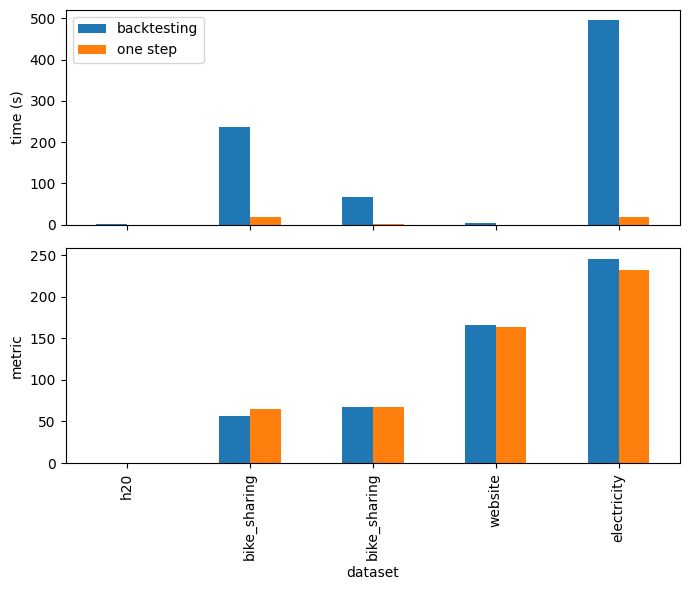

In [27]:
fig, axs = plt.subplots(2, 1, figsize=(7, 6), sharex=True)
results_grid_search.plot.bar(
    x='dataset',
    y=['time_search_backtesting', 'time_search_one_step'],
    ax=axs[0],
)
axs[0].set_ylabel('time (s)')
axs[0].legend(["backtesting", "one step"])
results_grid_search.plot.bar(
    x='dataset',
    y=['metric_backtesting', 'metric_one_step'],
    ax=axs[1],
    legend=False
)
axs[1].set_ylabel('metric')
plt.tight_layout()

### Bayesian search

In [13]:
# Table to store results
# ==============================================================================
results_bayesian_search = []

In [35]:
# Dataset: h2o
# ==============================================================================
end_train = "2001-01-01 23:59:00"
end_validation = "2006-01-01 23:59:00"
exog_features = None

forecaster = ForecasterAutoreg(
                regressor = LGBMRegressor(random_state=123, verbose=-1),
                lags      = 10
            )

lags_grid = [3, 10, [1, 2, 3, 20]]

def search_space(trial):
    search_space  = {
        'n_estimators'    : trial.suggest_int('n_estimators', 50, 500),
        'max_depth'       : trial.suggest_int('max_depth', 2, 10),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.001, 1),
        'lags'            : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space


time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_h2o,
    forecaster_to_benchmark = forecaster,
    search_method           = 'bayesian_search',
    search_space            = search_space,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'x',
    exog_features           = exog_features,
    steps                   = 24,
    metric                  = 'mean_absolute_error'
)
results_bayesian_search.append([
    'h2o',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

  0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'n_estimators': 428, 'max_depth': 8, 'learning_rate': 0.7454893153473452}
  Backtesting metric: 0.18078188410046167



/home/ubuntu/varios/skforecast/skforecast/model_selection/model_selection.py:1716: UserWarning: One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate.
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3 20] 
  Parameters: {'n_estimators': 375, 'max_depth': 4, 'learning_rate': 0.3624268669666918}
  Backtesting metric: 0.1323261748362944

Benchmark results
-----------------
Execution time backtesting   : 1.7116682529449463
Execution time one step ahead: 0.8359487056732178
Same lags  : False
Same params: False

Method: backtesting
    lags   : [1 2 3]
    params : {'n_estimators': 428, 'max_depth': 8, 'learning_rate': 0.7454893153473452}
    metrics: 0.21722368616634768

Method: one step ahead
    lags   : [ 1  2  3 20]
    params : {'n_estimators': 375, 'max_depth': 4, 'learning_rate': 0.3624268669666918}
    metrics: 0.22286485171242473


In [15]:
# Dataset: bike_sharing_extended_features
# ==============================================================================
end_train = '2012-03-31 23:59:00'
end_validation = '2012-08-31 23:59:00'
exog_features = [
    'month_sin', 'month_cos', 'week_of_year_sin', 'week_of_year_cos', 'week_day_sin',
    'week_day_cos', 'hour_day_sin', 'hour_day_cos', 'sunrise_hour_sin', 'sunrise_hour_cos',
    'sunset_hour_sin', 'sunset_hour_cos', 'holiday_previous_day', 'holiday_next_day',
    'temp_roll_mean_1_day', 'temp_roll_mean_7_day', 'temp_roll_max_1_day',
    'temp_roll_min_1_day', 'temp_roll_max_7_day', 'temp_roll_min_7_day',
    'temp', 'holiday'
]

forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 10
             )

lags_grid = [48, 72, (1, 2, 3, 23, 24, 25, 167, 168, 169)]

def search_space(trial):
    search_space  = {
        'n_estimators'    : trial.suggest_int('n_estimators', 400, 1200, step=100),
        'max_depth'       : trial.suggest_int('max_depth', 3, 10, step=1),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 1),
        'gamma'           : trial.suggest_float('gamma', 0, 1),
        'reg_alpha'       : trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda'      : trial.suggest_float('reg_lambda', 0, 1),
        'lags'            : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space


time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_bike,
    forecaster_to_benchmark = forecaster,
    search_method           = 'bayesian_search',
    search_space            = search_space,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'users',
    exog_features           = exog_features,
    steps                   = 24,
    metric                  = 'mean_absolute_error'
)
results_bayesian_search.append([
    'bike_sharing',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

  0%|          | 0/20 [00:00<?, ?it/s]

[W 2024-09-11 13:29:51,825] Trial 0 failed with parameters: {'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.2345829390285611, 'gamma': 0.5513147690828912, 'reg_alpha': 0.7194689697855631, 'reg_lambda': 0.42310646012446096, 'lags': 48} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/skforecast_13_py12/lib/python3.12/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/home/ubuntu/varios/skforecast/skforecast/model_selection/model_selection.py", line 1767, in _objective
    metrics, _ = backtesting_forecaster(
                 ^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ubuntu/varios/skforecast/skforecast/model_selection/model_selection.py", line 764, in backtesting_forecaster
    metric_values, backtest_predictions = _backtesting_forecaster(
                                          ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/hom

KeyboardInterrupt: 

In [28]:
# Dataset: website_visits
# ==============================================================================
end_train = '2021-03-30 23:59:00'
end_validation = '2021-06-30 23:59:00'
exog_features = [col for col in data_website.columns if col.startswith(('month_', 'week_day_', 'month_day_'))]

forecaster = ForecasterAutoreg(
                 regressor     = Ridge(random_state=123),
                 transformer_y = StandardScaler(),
                 lags          = 10
             )

lags_grid = [7, 14, 21, [7, 14, 21]]
def search_space(trial):
    search_space  = {
        'alpha' : trial.suggest_float('alpha', 0.001, 1000, log=True),
        'lags'  : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space


time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_website,
    forecaster_to_benchmark = forecaster,
    search_method           = 'bayesian_search',
    search_space            = search_space,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'users',
    exog_features           = exog_features,
    steps                   = 7,
    metric                  = 'mean_absolute_error'
)

results_bayesian_search.append([
    'website',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

  0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
  Parameters: {'alpha': 1.2524531789882662}
  Backtesting metric: 224.33854613853265



/home/ubuntu/varios/skforecast/skforecast/model_selection/model_selection.py:1742: UserWarning: One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate.
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
  Parameters: {'alpha': 2.083580929967405}
  Backtesting metric: 0.13822004658108406

Benchmark results
-----------------
Execution time backtesting   : 2.2080986499786377
Execution time one step ahead: 0.42618417739868164
Same lags  : True
Same params: False

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
    params : {'alpha': 1.2524531789882662}
    metrics: 166.84400582475766

Method: one step ahead
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
    params : {'alpha': 2.083580929967405}
    metrics: 164.24239262308248


In [29]:
# Dataset: vic_electricity
# ==============================================================================
end_train = '2013-12-31 23:59:00'
end_validation = '2014-11-30 23:59:00'
exog_features = ['Temperature', 'Holiday']

forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 10
             )

lags_grid = [48, 72, (1, 2, 3, 23, 24, 25, 167, 168, 169)]

def search_space(trial):
    search_space  = {
        'n_estimators'    : trial.suggest_int('n_estimators', 400, 1200, step=100),
        'max_depth'       : trial.suggest_int('max_depth', 3, 10, step=1),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 1),
        'gamma'           : trial.suggest_float('gamma', 0, 1),
        'reg_alpha'       : trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda'      : trial.suggest_float('reg_lambda', 0, 1),
        'lags'            : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space


time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data,
    forecaster_to_benchmark = forecaster,
    search_method           = 'bayesian_search',
    search_space            = search_space,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'Demand',
    exog_features           = exog_features,
    steps                   = 24,
    metric                  = 'mean_absolute_error'
)
results_bayesian_search.append([
    'electricity',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

  0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3  23  24  25 167 168 169] 
  Parameters: {'n_estimators': 1200, 'max_depth': 10, 'learning_rate': 0.056896300053531614, 'gamma': 0.2725691628660212, 'reg_alpha': 0.24605588251006993, 'reg_lambda': 0.9687485406819449}
  Backtesting metric: 188.96351468130305



/home/ubuntu/varios/skforecast/skforecast/model_selection/model_selection.py:1742: UserWarning: One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate.
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3  23  24  25 167 168 169] 
  Parameters: {'n_estimators': 1200, 'max_depth': 10, 'learning_rate': 0.056896300053531614, 'gamma': 0.2725691628660212, 'reg_alpha': 0.24605588251006993, 'reg_lambda': 0.9687485406819449}
  Backtesting metric: 55.39272803132169

Benchmark results
-----------------
Execution time backtesting   : 182.36443424224854
Execution time one step ahead: 41.86243534088135
Same lags  : True
Same params: True

Method: backtesting
    lags   : [  1   2   3  23  24  25 167 168 169]
    params : {'n_estimators': 1200, 'max_depth': 10, 'learning_rate': 0.056896300053531614, 'gamma': 0.2725691628660212, 'reg_alpha': 0.24605588251006993, 'reg_lambda': 0.9687485406819449}
    metrics: 256.0923891003333

Method: one step ahead
    lags   : [  1   2   3  23  24  25 167 168 169]
    params : {'n_estimators': 1200, 'max_depth': 10, 'learning_rate': 0.056896300053531614, 'ga

In [36]:
results_bayesian_search = pd.DataFrame(
    results_bayesian_search, 
    columns=[
        "dataset",
        "forecaster",
        "time_search_backtesting",
        "time_search_one_step",
        "metric_backtesting",
        "metric_one_step",
    ]
)
results_bayesian_search

,dataset,forecaster,time_search_backtesting,time_search_one_step,metric_backtesting,metric_one_step
0,h2o,ForecasterAutoreg,1.707060,0.857938,0.217224,0.220279
1,bike_sharing_extended_features,ForecasterAutoreg,102.389656,41.211960,55.110738,55.110738
2,bike_sharing,ForecasterAutoreg,95.979248,6.691473,44.665721,44.665721
3,website,ForecasterAutoreg,2.208099,0.426184,166.844006,164.242393
4,electricity,ForecasterAutoreg,182.364434,41.862435,256.092389,256.092389


AttributeError: 'list' object has no attribute 'plot'

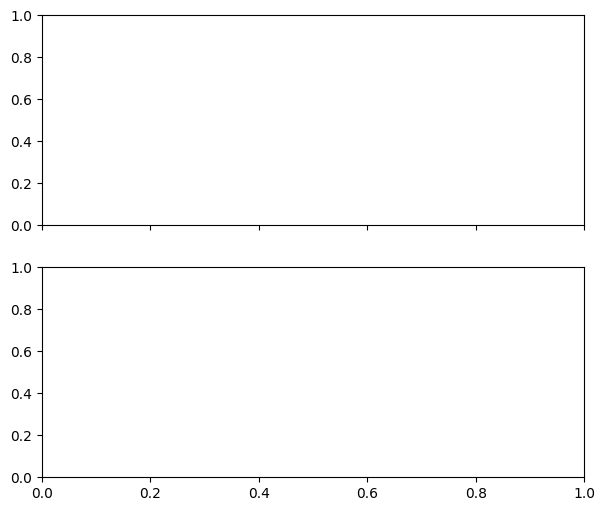

In [28]:
fig, axs = plt.subplots(2, 1, figsize=(7, 6), sharex=True)
results_bayesian_search.plot.bar(
    x='dataset',
    y=['time_search_backtesting', 'time_search_one_step'],
    ax=axs[0],
)
axs[0].set_ylabel('time (s)')
axs[0].legend(["backtesting", "one step"])
results_bayesian_search.plot.bar(
    x='dataset',
    y=['metric_backtesting', 'metric_one_step'],
    ax=axs[1],
    legend=False
)
axs[1].set_ylabel('metric')
plt.tight_layout()

## Global models (multiple series forecasters)

In [9]:
# Functions to compare results using backtesting and one step ahead
# ==============================================================================
def run_benchmark_multiseries(
    data = None,
    forecaster_to_benchmark = None,
    search_method = None,
    lags_grid = None,
    param_grid = None,
    search_space = None,
    end_train = None,
    end_validation = None,
    levels = None,
    exog_features = None,
    steps = None,
    metric = None
):
    """
    Compare results of grid search using backtesting and one-step-ahead.
    """
    
    # Backtesting
    forecaster = copy(forecaster_to_benchmark)
    start  = time()
    if search_method == 'grid_search':
        results_1 = grid_search_forecaster_multiseries(
                        forecaster         = forecaster,
                        series             = data.loc[:end_validation, levels],
                        levels             = levels,
                        exog               = data.loc[:end_validation, exog_features] if exog_features else None,
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = False,
                        metric             = metric,
                        initial_train_size = len(data.loc[:end_train]),
                        method             = 'backtesting',
                        fixed_train_size   = False,
                        return_best        = True,
                        n_jobs             = 'auto',
                        verbose            = False,
                        show_progress      = True
                    )
    else:
        results_1, _ = bayesian_search_forecaster_multiseries(
                        forecaster         = forecaster,
                        series             = data.loc[:end_validation, levels],
                        exog               = data.loc[:end_validation, exog_features] if exog_features else None,
                        levels             = levels,
                        search_space       = search_space,
                        steps              = steps,
                        refit              = False,
                        metric             = metric,
                        initial_train_size = len(data.loc[:end_train]),
                        method             = 'backtesting',
                        fixed_train_size   = False,
                        n_trials           = 15,
                        random_state       = 123,
                        return_best        = True,
                        n_jobs             = 'auto',
                        verbose            = False,
                        show_progress      = True
                    )
    end = time()
    time_1 = end - start
    metric_1, pred_1 = backtesting_forecaster_multiseries(
                            forecaster          = forecaster,
                            series              = data.loc[:, levels],
                            exog                = data.loc[:, exog_features] if exog_features else None,
                            initial_train_size  = len(data.loc[:end_validation]),
                            levels              = levels,
                            steps               = steps,
                            metric              = metric,
                            verbose             = False,
                            show_progress       = False
                        )

    # One step ahead
    forecaster = copy(forecaster_to_benchmark)
    start  = time()
    if search_method == 'grid_search':
        results_2 = grid_search_forecaster_multiseries(
                        forecaster         = forecaster,
                        series             = data.loc[:end_validation, levels],
                        exog               = data.loc[:end_validation, exog_features] if exog_features else None,
                        levels             = levels,
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        metric             = metric,
                        initial_train_size = len(data.loc[:end_train]),
                        method             = 'one_step_ahead',
                        return_best        = True,
                        verbose            = False,
                        show_progress      = True
                    )
    else:
        results_2, _ = bayesian_search_forecaster_multiseries(
                        forecaster         = forecaster,
                        series             = data.loc[:end_validation, levels],
                        exog               = data.loc[:end_validation, exog_features] if exog_features else None,
                        levels             = levels,
                        steps              = steps,
                        search_space       = search_space,
                        metric             = metric,
                        initial_train_size = len(data.loc[:end_train]),
                        method             = 'one_step_ahead',
                        n_trials           = 15,
                        random_state       = 123,
                        return_best        = True,
                        verbose            = False,
                        show_progress      = True
                    )

    end = time()
    time_2 = end - start
    metric_2, pred_2 = backtesting_forecaster_multiseries(
                            forecaster          = forecaster,
                            series              = data.loc[:, levels],
                            exog                = data.loc[:, exog_features] if exog_features else None,
                            levels              = levels,
                            initial_train_size  = len(data.loc[:end_validation]),
                            steps               = steps,
                            metric              = metric,
                            verbose             = False,
                            show_progress       = False
                        )

    print("Benchmark results")
    print("-----------------")
    print('Execution time backtesting   :', time_1)
    print('Execution time one step ahead:', time_2)
    print(f"Same lags  : {np.array_equal(results_1.loc[0, 'lags'], results_2.loc[0, 'lags'])}")
    print(f"Same params: {results_1.loc[0, 'params'] == results_2.loc[0, 'params']}")
    print("")
    print("Method: backtesting")
    print(f"    lags   : {results_1.loc[0, 'lags']}")
    print(f"    params : {results_1.loc[0, 'params']}")
    print(f"    metrics: {metric_1.loc[0, metric]}")
    print("")
    print("Method: one step ahead")
    print(f"    lags   : {results_2.loc[0, 'lags']}")
    print(f"    params : {results_2.loc[0, 'params']}")
    print(f"    metrics: {metric_2.loc[0, metric]}")
    
    return time_1, time_2, metric_1.loc[0, metric], metric_2.loc[0, metric]

### Grid search

In [10]:
results_grid_search_multiseries = []

In [11]:
# Dataset: sales
# ==============================================================================
end_train = '2014-05-15 23:59:00'
end_validation = '2014-07-15 23:59:00'
levels = ['item_1', 'item_2', 'item_3']
exog_features = None 

forecaster = ForecasterAutoregMultiSeries(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1),
                 lags               = 24,
                 encoding           = "ordinal",
                 transformer_series = None,
                 transformer_exog   = None,
                 weight_func        = None,
                 series_weights     = None,
                 differentiation    = None,
                 dropna_from_series = False,
                 fit_kwargs         = None,
                 forecaster_id      = None
             )

lags_grid = {
    '24 lags': 24,
    '48 lags': 48
}

param_grid = {
    'n_estimators': [10, 20],
    'max_depth': [3, 7]
}

time_1, time_2, metric_1, metric_2 = run_benchmark_multiseries(
    data                    = data_sales,
    forecaster_to_benchmark = forecaster,
    search_method           = 'grid_search',
    lags_grid               = lags_grid,
    param_grid              = param_grid,
    end_train               = end_train,
    end_validation          = end_validation,
    levels                  = levels,
    exog_features           = exog_features,
    steps                   = 36,
    metric                  = 'mean_absolute_error'
)
results_grid_search_multiseries.append([
    'sales',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
  Parameters: {'max_depth': 7, 'n_estimators': 20}
  Backtesting metric: 2.281107158900761
  Levels: ['item_1', 'item_2', 'item_3']



/home/ubuntu/varios/skforecast/skforecast/model_selection_multiseries/model_selection_multiseries.py:1708: UserWarning: One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate.
  warnings.warn(


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'max_depth': 3, 'n_estimators': 20}
  Backtesting metric: 1.7788941749503342
  Levels: ['item_1', 'item_2', 'item_3']

Benchmark results
-----------------
Execution time backtesting   : 1.6784987449645996
Execution time one step ahead: 0.4837038516998291
Same lags  : False
Same params: False

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
    params : {'max_depth': 7, 'n_estimators': 20}
    metrics: 1.43839579684015

Method: one step ahead
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48]
    params : {'max_depth': 3, 'n_estimators': 20}
    metrics: 1.6408350320

In [12]:
# Dataset: sales
# ==============================================================================
forecaster = ForecasterAutoregMultiVariate(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1),
                 lags               = 24,
                 steps              = 5,
                 level              = 'item_1',
                 transformer_series = None,
                 transformer_exog   = None,
                 weight_func        = None,
                 fit_kwargs         = None,
                 forecaster_id      = None
             )

lags_grid ={
    '24 lags': 24,
    '48 lags': 48
}

param_grid = {
    'n_estimators': [10, 20],
    'max_depth': [3, 7]
}

time_1, time_2, metric_1, metric_2 = run_benchmark_multiseries(
    data                    = data_sales,
    forecaster_to_benchmark = forecaster,
    search_method           = 'grid_search',
    lags_grid               = lags_grid,
    param_grid              = param_grid,
    end_train               = end_train,
    end_validation          = end_validation,
    levels                  = levels,
    exog_features           = exog_features,
    steps                   = 5,
    metric                  = 'mean_absolute_error'
)

results_grid_search_multiseries.append([
    'sales',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'max_depth': 7, 'n_estimators': 20}
  Backtesting metric: 0.6819591626794975
  Levels: ['item_1']



/home/ubuntu/varios/skforecast/skforecast/model_selection_multiseries/model_selection_multiseries.py:1708: UserWarning: One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate.
  warnings.warn(


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
  Parameters: {'max_depth': 7, 'n_estimators': 20}
  Backtesting metric: 0.743055091298141
  Levels: ['item_1']

Benchmark results
-----------------
Execution time backtesting   : 2.8022353649139404
Execution time one step ahead: 1.9450428485870361
Same lags  : False
Same params: True

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48]
    params : {'max_depth': 7, 'n_estimators': 20}
    metrics: 1.0409310906937037

Method: one step ahead
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
    params : {'max_depth': 7, 'n_estimators': 20}
    metrics: 1.0481118869071948


In [13]:
results_grid_search_multiseries = pd.DataFrame(
    results_grid_search_multiseries,
    columns=[
        "dataset",
        "forecaster",
        "time_search_backtesting",
        "time_search_one_step",
        "metric_backtesting",
        "metric_one_step",
    ]
)
results_grid_search_multiseries

,dataset,forecaster,time_search_backtesting,time_search_one_step,metric_backtesting,metric_one_step
0,sales,ForecasterAutoregMultiSeries,1.678499,0.483704,1.438396,1.640835
1,sales,ForecasterAutoregMultiVariate,2.802235,1.945043,1.040931,1.048112


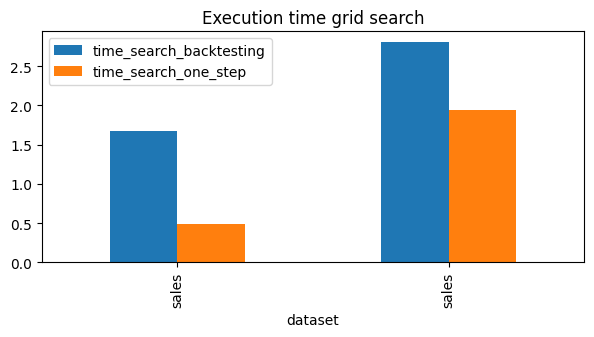

In [14]:
fig, axs = plt.subplots(2, 1, figsize=(7, 6), sharex=True)
results_grid_search_multiseries.plot.bar(
    x='dataset',
    y=['time_search_backtesting', 'time_search_one_step'],
    ax=axs[0],
)
axs[0].set_ylabel('time (s)')
axs[0].legend(["backtesting", "one step"])
results_grid_search_multiseries.plot.bar(
    x='dataset',
    y=['metric_backtesting', 'metric_one_step'],
    ax=axs[1],
    legend=False
)
axs[1].set_ylabel('metric')
plt.tight_layout()

### Bayesian search

In [15]:
results_bayesian_search_multiseries = []

In [16]:
# Dataset: sales
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1),
                 lags               = 24,
                 encoding           = "ordinal",
                 transformer_series = None,
                 transformer_exog   = None,
                 weight_func        = None,
                 series_weights     = None,
                 differentiation    = None,
                 dropna_from_series = False,
                 fit_kwargs         = None,
                 forecaster_id      = None
             )

lags_grid = [48, 72]

def search_space(trial):
    search_space  = {
        'n_estimators'    : trial.suggest_int('n_estimators', 10, 50),
        'max_depth'       : trial.suggest_int('max_depth', 3, 10, step=1),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 1),
        'lags'            : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space

time_1, time_2, metric_1, metric_2 = run_benchmark_multiseries(
    data                    = data_sales,
    forecaster_to_benchmark = forecaster,
    search_method           = 'bayesian_search',
    search_space            = search_space,
    end_train               = end_train,
    end_validation          = end_validation,
    levels                  = levels,
    exog_features           = exog_features,
    steps                   = 36,
    metric                  = 'mean_absolute_error'
)
results_bayesian_search_multiseries.append([
    'sales',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

  0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'n_estimators': 47, 'max_depth': 10, 'learning_rate': 0.10582782597735779}
  Backtesting metric: 1.9340570479344343
  Levels: ['item_1', 'item_2', 'item_3']



/home/ubuntu/varios/skforecast/skforecast/model_selection_multiseries/model_selection_multiseries.py:2292: UserWarning: One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate.
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'n_estimators': 35, 'max_depth': 3, 'learning_rate': 0.3241126270021177}
  Backtesting metric: 1.586531587692841
  Levels: ['item_1', 'item_2', 'item_3']

Benchmark results
-----------------
Execution time backtesting   : 5.1049957275390625
Execution time one step ahead: 1.8923134803771973
Same lags  : False
Same params: False

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48]
    params : {'n_estimators': 47, 'max_depth': 10, 'learning_rate': 0.10582782597735779}
    metrics: 1.2509853110935267

Method: one step ahead
    lags   :

In [17]:
# Dataset: sales
# ==============================================================================
forecaster = ForecasterAutoregMultiVariate(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1),
                 lags               = 24,
                 steps              = 5,
                 level              = 'item_1',
                 transformer_series = None,
                 transformer_exog   = None,
                 weight_func        = None,
                 fit_kwargs         = None,
                 forecaster_id      = None
             )

lags_grid = [48, 72]

def search_space(trial):
    search_space  = {
        'n_estimators'    : trial.suggest_int('n_estimators', 10, 50),
        'max_depth'       : trial.suggest_int('max_depth', 3, 10, step=1),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 1),
        'lags'            : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space

time_1, time_2, metric_1, metric_2 = run_benchmark_multiseries(
    data                    = data_sales,
    forecaster_to_benchmark = forecaster,
    search_method           = 'bayesian_search',
    search_space            = search_space,
    end_train               = end_train,
    end_validation          = end_validation,
    levels                  = levels,
    exog_features           = exog_features,
    steps                   = 5,
    metric                  = 'mean_absolute_error'
)
results_bayesian_search_multiseries.append([
    'sales',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

/home/ubuntu/varios/skforecast/skforecast/model_selection_multiseries/model_selection_multiseries.py:83: IgnoredArgumentWarning: `levels` argument have no use when the forecaster is of type `ForecasterAutoregMultiVariate`. The level of this forecaster is 'item_1', to predict another level, change the `level` argument when initializing the forecaster. 
 
 You can suppress this warning using: warnings.simplefilter('ignore', category=IgnoredArgumentWarning)
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'n_estimators': 50, 'max_depth': 8, 'learning_rate': 0.11386606446550962}
  Backtesting metric: 0.7040404186172173
  Levels: ['item_1']



/home/ubuntu/varios/skforecast/skforecast/model_selection_multiseries/model_selection_multiseries.py:83: IgnoredArgumentWarning: `levels` argument have no use when the forecaster is of type `ForecasterAutoregMultiVariate`. The level of this forecaster is 'item_1', to predict another level, change the `level` argument when initializing the forecaster. 
 
 You can suppress this warning using: warnings.simplefilter('ignore', category=IgnoredArgumentWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/model_selection_multiseries/model_selection_multiseries.py:2292: UserWarning: One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate.
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/model_selection_multiseries/model_selection_multiseries.py:83: IgnoredArgumentWarning: `levels` argument have no 

  0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'n_estimators': 50, 'max_depth': 8, 'learning_rate': 0.11386606446550962}
  Backtesting metric: 0.771352363294828
  Levels: ['item_1']



/home/ubuntu/varios/skforecast/skforecast/model_selection_multiseries/model_selection_multiseries.py:83: IgnoredArgumentWarning: `levels` argument have no use when the forecaster is of type `ForecasterAutoregMultiVariate`. The level of this forecaster is 'item_1', to predict another level, change the `level` argument when initializing the forecaster. 
 
 You can suppress this warning using: warnings.simplefilter('ignore', category=IgnoredArgumentWarning)
  warnings.warn(


Benchmark results
-----------------
Execution time backtesting   : 16.560529470443726
Execution time one step ahead: 12.978951215744019
Same lags  : True
Same params: True

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48]
    params : {'n_estimators': 50, 'max_depth': 8, 'learning_rate': 0.11386606446550962}
    metrics: 1.0172431291661241

Method: one step ahead
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48]
    params : {'n_estimators': 50, 'max_depth': 8, 'learning_rate': 0.11386606446550962}
    metrics: 1.0172431291661241


In [18]:
results_bayesian_search_multiseries = pd.DataFrame(
    results_bayesian_search_multiseries,
    columns=[
        "dataset",
        "forecaster",
        "time_search_backtesting",
        "time_search_one_step",
        "metric_backtesting",
        "metric_one_step",
    ]
)
results_bayesian_search_multiseries

,dataset,forecaster,time_search_backtesting,time_search_one_step,metric_backtesting,metric_one_step
0,sales,ForecasterAutoregMultiSeries,1.678499,0.483704,1.438396,1.640835
1,sales,ForecasterAutoregMultiVariate,2.802235,1.945043,1.040931,1.048112


In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(7, 6), sharex=True)
results_bayesian_search_multiseries.plot.bar(
    x='dataset',
    y=['time_search_backtesting', 'time_search_one_step'],
    ax=axs[0],
)
axs[0].set_ylabel('time (s)')
axs[0].legend(["backtesting", "one step"])
results_bayesian_search_multiseries.plot.bar(
    x='dataset',
    y=['metric_backtesting', 'metric_one_step'],
    ax=axs[1],
    legend=False
)
axs[1].set_ylabel('metric')
plt.tight_layout()

# Unit test

## _evaluate_grid_hyperparameters: backtesting vs one-step-ahead

In [19]:
from skforecast.model_selection.model_selection import _evaluate_grid_hyperparameters
from sklearn.model_selection import ParameterGrid

In [20]:
# Data
# ==============================================================================
data = fetch_dataset(
    name="h2o",
    raw=True,
    kwargs_read_csv={"names": ["y", "datetime"], "header": 0},
    verbose=False,
)
data["datetime"] = pd.to_datetime(data["datetime"], format="%Y-%m-%d")
data = data.set_index("datetime")
data = data.asfreq("MS")
data = data[["y"]]
data = data.sort_index()
end_train = "2001-01-01 23:59:00"
end_validation = "2006-01-01 23:59:00"
target = "y"
exog_features = None

In [21]:
forecaster = ForecasterAutoreg(
                regressor = LGBMRegressor(random_state=123, verbose=-1),
                lags      = 10
            )
lags_grid = [3, 10, [1, 2, 3, 20]]
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [2, 3, 5]
}
param_grid = list(ParameterGrid(param_grid))

results_backtesting = _evaluate_grid_hyperparameters(
    forecaster         = forecaster,
    y                  = data.loc[:end_validation, target],
    exog               = data.loc[:end_validation, exog_features] if exog_features else None,
    param_grid         = param_grid,
    lags_grid          = lags_grid,
    steps              = 1,
    method             = 'backtesting',
    refit              = False,
    metric             = ['mean_squared_error', 'mean_absolute_error'],
    initial_train_size = len(data.loc[:end_train]),
    fixed_train_size   = False,
    return_best        = False,
    n_jobs             = 'auto',
    verbose            = False,
    show_progress      = False
)

results_one_step_ahead = _evaluate_grid_hyperparameters(
    forecaster         = forecaster,
    y                  = data.loc[:end_validation, target],
    exog               = data.loc[:end_validation, exog_features] if exog_features else None,
    param_grid         = param_grid,
    lags_grid          = lags_grid,
    metric             = ['mean_squared_error', 'mean_absolute_error'],
    initial_train_size = len(data.loc[:end_train]),
    method             = 'one_step_ahead',
    return_best        = False,
    verbose            = False,
    show_progress      = False
)

assert results_backtesting.equals(results_one_step_ahead)

/home/ubuntu/varios/skforecast/skforecast/model_selection/model_selection.py:1257: UserWarning: One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate.
  warnings.warn(


## _calculate_metrics_multiseries vs _calculate_metrics_multiseries_one_step_ahead

In [22]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from skforecast.model_selection_multiseries.model_selection_multiseries import _calculate_metrics_multiseries_one_step_ahead
from skforecast.model_selection_multiseries.model_selection_multiseries import _calculate_metrics_multiseries
from skforecast.model_selection.model_selection import _create_backtesting_folds
from skforecast.metrics import add_y_train_argument
from skforecast.metrics import mean_absolute_scaled_error

In [23]:
# Data download
# ==============================================================================
data = fetch_dataset(name="items_sales")
end_train = '2014-07-15 23:59:00'
data_train = data.loc[:end_train, :].copy()
data_test  = data.loc[end_train:, :].copy()

items_sales
-----------
Simulated time series for the sales of 3 different items.
Simulated data.
Shape of the dataset: (1097, 3)


In [24]:
forecaster = ForecasterAutoregMultiSeries(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1),
                 lags               = 24,
                 encoding           = 'ordinal',
                 transformer_series = None,
                 transformer_exog   = None,
                 weight_func        = None,
                 series_weights     = None,
                 differentiation    = None,
                 dropna_from_series = False,
                 fit_kwargs         = None,
                 forecaster_id      = None
             )

X, y = forecaster.create_train_X_y(series=data)
X_train = X.loc[X.index <= end_train, :]
y_train = y.loc[y.index <= end_train]
X_test = X.loc[X.index > end_train, :]
y_test = y.loc[y.index > end_train]

forecaster.regressor.fit(X_train, y_train)
pred = forecaster.regressor.predict(X_test)

In [25]:
# Test results _calculate_metrics_multiseries_one_step_ahead and _calculate_metrics_multiseries
# ==============================================================================
# Metrics should be equal when using step=1 in backtesting

# Metrics with _calculate_metrics_multiseries_one_step_ahead
metrics = [mean_absolute_error, mean_absolute_percentage_error, mean_absolute_scaled_error]
metrics = [add_y_train_argument(metric) for metric in metrics]

if forecaster.encoding in ['ordinal', 'ordinal_category']:
    X_train_encoding = forecaster.encoder.inverse_transform(X_train[['_level_skforecast']]).ravel()
    X_test_encoding = forecaster.encoder.inverse_transform(X_test[['_level_skforecast']]).ravel()
elif forecaster.encoding == 'onehot':
    X_train_encoding = forecaster.encoder.inverse_transform(
                            X_train.loc[:, forecaster.encoding_mapping.keys()]
                        ).ravel()
    X_test_encoding = forecaster.encoder.inverse_transform(
                            X_test.loc[:, forecaster.encoding_mapping.keys()]
                        ).ravel()

metrics_one_step_ahead = _calculate_metrics_multiseries_one_step_ahead(
    y_true = y_test.to_numpy(),
    y_true_index = y_test.index,
    y_pred = pred,
    y_pred_encoding = X_test_encoding,
    y_train = y_train.to_numpy(),
    y_train_index = y_train.index,
    y_train_encoding = X_train_encoding,
    levels = ['item_1', 'item_2', 'item_3'],
    metrics = metrics,
    add_aggregated_metric = True
)

display(metrics_one_step_ahead)

# Metrics with _calculate_metrics_multiseries
folds = _create_backtesting_folds(
    data = data,
    window_size = 24,
    initial_train_size = len(data_train),
    test_size = 1,
    externally_fitted = False,
    refit = False,
    fixed_train_size = True,
    gap = 0,
    skip_folds = None,
    allow_incomplete_fold = True,
    return_all_indexes = False,
    differentiation = None,
    verbose = False
)
_, predictions = backtesting_forecaster_multiseries(
    series=data,
    forecaster=forecaster,
    steps=1,
    metric=metrics,
    initial_train_size = len(data_train),
    refit=False,
    add_aggregated_metric=True,
    show_progress=False
)
metrics_backtesting = _calculate_metrics_multiseries(
    series = data,
    predictions= predictions,
    folds= folds,
    span_index= data.index,
    window_size = 24,
    metrics= metrics,
    levels= ['item_1', 'item_2', 'item_3'],
    add_aggregated_metric = True
)

display(metrics_backtesting)

assert metrics_backtesting.equals(metrics_one_step_ahead)

,levels,mean_absolute_error,mean_absolute_percentage_error,mean_absolute_scaled_error
0,item_1,0.820748,0.040761,0.537711
1,item_2,2.330964,0.152464,0.989540
2,item_3,3.093253,0.207347,0.835301
3,average,2.081655,0.133524,0.787517
4,weighted_average,2.081655,0.133524,0.787517
5,pooling,2.081655,0.133524,0.823316


,levels,mean_absolute_error,mean_absolute_percentage_error,mean_absolute_scaled_error
0,item_1,0.820748,0.040761,0.537711
1,item_2,2.330964,0.152464,0.989540
2,item_3,3.093253,0.207347,0.835301
3,average,2.081655,0.133524,0.787517
4,weighted_average,2.081655,0.133524,0.787517
5,pooling,2.081655,0.133524,0.823316


## _evaluate_grid_hyperparameters_multiseries: backtesting vs one-step-ahead

In [26]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from skforecast.model_selection_multiseries.model_selection_multiseries import _evaluate_grid_hyperparameters_multiseries
from skforecast.metrics import mean_absolute_scaled_error

In [27]:
# Data download
# ==============================================================================
data = fetch_dataset(name="items_sales")
end_train = '2014-07-15 23:59:00'
data_train = data.loc[:end_train, :].copy()
data_test  = data.loc[end_train:, :].copy()
exog_features = None

items_sales
-----------
Simulated time series for the sales of 3 different items.
Simulated data.
Shape of the dataset: (1097, 3)


In [28]:
forecaster = ForecasterAutoregMultiSeries(
    regressor          = LGBMRegressor(random_state=123, verbose=-1),
    lags               = 24,
    encoding           = 'ordinal',
    transformer_series = None,
    transformer_exog   = None,
    weight_func        = None,
    series_weights     = None,
    differentiation    = None,
    dropna_from_series = False,
    fit_kwargs         = None,
    forecaster_id      = None
)
lags_grid = [3, 10]
param_grid = {
    'n_estimators': [5, 10],
    'max_depth': [2, 3]
}
param_grid = list(ParameterGrid(param_grid))

results_backtesting = _evaluate_grid_hyperparameters_multiseries(
                            forecaster            = forecaster,
                            series                = data,
                            param_grid            = param_grid,
                            steps                 = 1,
                            metric                = metrics,
                            aggregate_metric      = ['weighted_average', 'average', 'pooling'],
                            initial_train_size    = len(data_train),
                            method                = 'backtesting',
                            fixed_train_size      = True,
                            gap                   = 0,
                            skip_folds            = None,
                            allow_incomplete_fold = True,
                            levels                = None,
                            exog                  = data.loc[:end_validation, exog_features] if exog_features else None,
                            lags_grid             = lags_grid,
                            refit                 = False,
                            n_jobs                = 'auto',
                            return_best           = False,
                            verbose               = False,
                            show_progress         = False,
                            suppress_warnings     = False
                        )

results_one_step_ahead = _evaluate_grid_hyperparameters_multiseries(
                            forecaster            = forecaster,
                            series                = data,
                            param_grid            = param_grid,
                            metric                = metrics,
                            initial_train_size    = len(data_train),
                            method                = 'one_step_ahead',
                            exog                  = data.loc[:data_train, exog_features] if exog_features else None,
                            lags_grid             = lags_grid,
                            return_best           = False,
                            verbose               = False,
                            show_progress         = False
                        )

assert results_backtesting.equals(results_one_step_ahead)


/home/ubuntu/varios/skforecast/skforecast/model_selection_multiseries/model_selection_multiseries.py:1708: UserWarning: One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate.
  warnings.warn(
